In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

## Change-point detection for binary time series

Imagine that it's your job to make sure a certain server is up and running as often as possible. Every day for the past year, you've recorded a "0" in your log if the server didn't crash that day, and a "1" if it did crash. Unfortunately, you're pretty sure that crashes are more frequent now than they were at the beginning of the year, probably because of some bad deployment you made at some point.

Now, you need to look at the logs and see if crashes are actually more common now than they were before. If they are more common, find out roughly when the bad deployment probably happened. That is, given a sequence $\{C_n\}_{n=0}^{364}$ of 0s and 1s, determine whether the probabilty of getting a 1 is higher at the end than at the beginning. Then, if it is higher, estimate the point in time $n_0$ when the probability went up.

This is a hard problem with more than one valid approach! It's ok to propose a solution you don't think is optimal.

In [14]:
C = np.array(
   [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
    0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
    0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
    0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
    0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
    0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
    0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0.,
    0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
    1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
    1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
    1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
    1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
    0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
    0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
    0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
    0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
    0., 0., 0., 1., 1., 0., 1., 0.])

### Moving average

A 30-day moving average gives a general indication of monthly trends. 

In [15]:
ma = np.convolve(C, np.ones(30)/30, mode="same")

Text(0.5, 0, 'day of year')

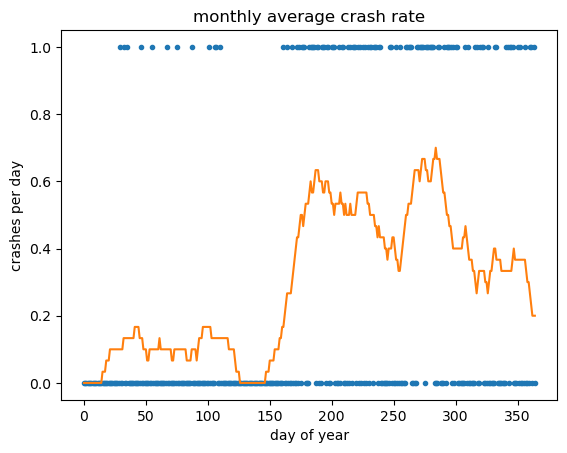

In [51]:
plt.plot(C, ".")
plt.plot(ma)
plt.title("monthly average crash rate")
plt.ylabel("crashes per day")
plt.xlabel("day of year")

It seems like the bad deployment might have been around day 160 or 170, since the aaverage is consistently higher after that.

## Binomial distribution

If we knew what the crash rate was before ($p$) and after ($q$) the change, we could assign a probability that the change occurred at time $t$ by computing the sum of `C[:t]` and of `C[t:]`, and comparing them to $tp$ and $(365-t)q$.

We don't know $p$ or $q$, but we can use the moving average to help estimate them. If you look at the plot, it's clear that the change must have happened between day 100 and day 200. So, $p$ and $q$ are well estimated by the means of `C[:100]` and `C[200:]`.

In [54]:
p = np.mean(C[:100])
q = np.mean(C[200:])
p, q

(0.08, 0.46060606060606063)

In [55]:
def P(t):
    p0 = scipy.stats.binom.pmf(np.sum(C[:t]), t, p)
    p1 = scipy.stats.binom.pmf(np.sum(C[t:]), len(C)-t, q)
    return p0*p1

In [56]:
ts = np.arange(100, 264)
pt = np.array([P(t) for t in ts])
pt /= np.sum(pt)

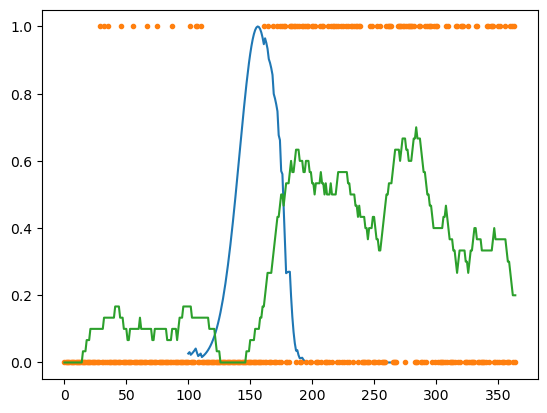

In [57]:
plt.plot(ts, pt/np.max(pt))
plt.plot(C, ".")
plt.plot(ma)